In [2]:
from utils.paper_extraction import *
from utils.commonfunctions import *
import cv2
import pandas as pd


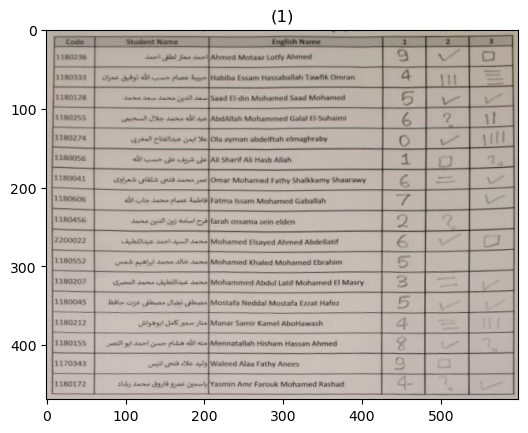

(469, 599, 3)


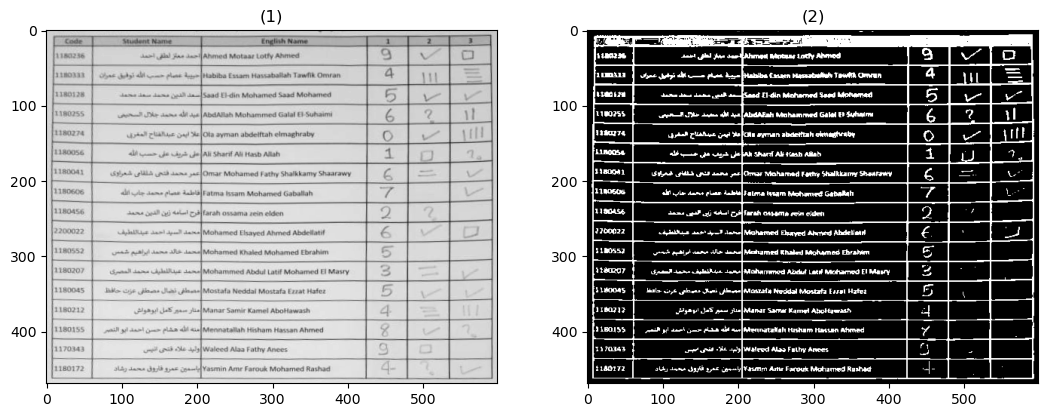

Binary shape: (469, 599)


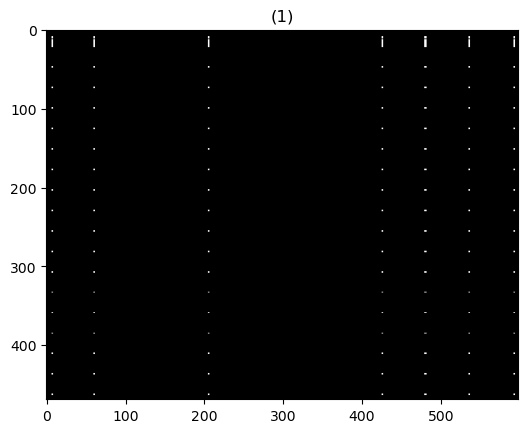

(469, 599)


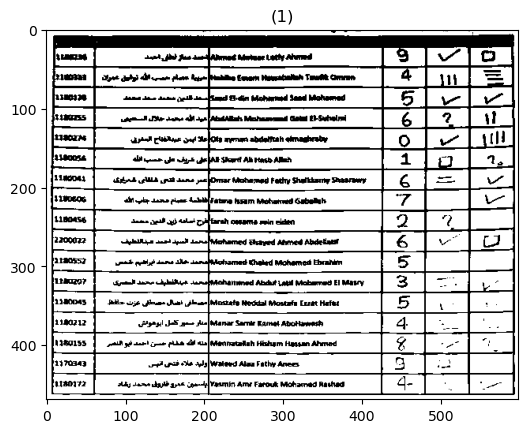

White percentage: 76.98189235079076
firstRow 22
Rows:  [[(7, 22), (8, 22), (60, 22), (61, 22), (205, 22), (206, 22), (425, 22), (426, 22), (479, 22), (480, 22), (481, 22), (535, 22), (536, 22), (592, 22), (593, 22)], [(7, 47), (8, 47), (60, 47), (61, 47), (205, 47), (206, 47), (425, 47), (426, 47), (479, 47), (480, 47), (481, 47), (535, 47), (536, 47), (592, 47), (593, 47)], [(7, 73), (8, 73), (60, 73), (61, 73), (205, 73), (206, 73), (425, 73), (426, 73), (479, 73), (480, 73), (481, 73), (535, 73), (536, 73), (592, 73), (593, 73)], [(7, 99), (8, 99), (60, 99), (61, 99), (205, 99), (206, 99), (425, 99), (426, 99), (479, 99), (480, 99), (481, 99), (535, 99), (536, 99), (592, 99), (593, 99)], [(7, 125), (8, 125), (60, 125), (61, 125), (205, 125), (206, 125), (425, 125), (426, 125), (479, 125), (480, 125), (481, 125), (535, 125), (536, 125), (592, 125), (593, 125)], [(7, 151), (8, 151), (60, 151), (61, 151), (205, 151), (206, 151), (425, 151), (426, 151), (479, 151), (480, 151), (481, 151

In [3]:
def houghLines(img, type):
    lines = cv.HoughLinesP(img.astype(np.uint8), 0.5, np.pi/180, 100,
                           minLineLength=0.25*min(img.shape[0], img.shape[1]), maxLineGap=10)

    hough_lines_out = np.zeros(img.shape)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if (type == "vertical"):
            cv.line(hough_lines_out, (x1, 0),
                    (x2, img.shape[0]), (255, 255, 255), 1)
        else:
            cv.line(hough_lines_out, (0, y1),
                    (img.shape[1], y2), (255, 255, 255), 1)
    return hough_lines_out


def threshold_intersections(pixels,ignoreCornerPoint= False, widthThresholdLow=20 , widthThresholdHigh=1400, heightThresholdLow=8, heightThresholdHigh=120):
    yMap = {}
    for i in range(pixels.shape[0]):
        for j in range(pixels.shape[1]):
            if pixels[i][j] != 0:
                if i in yMap:
                    yMap[i].append((j, i))
                else:
                    yMap[i] = []
                    yMap[i].append((j, i))

    yPixels = list(yMap.keys())
    rows = []   

    # find the first row y coord
    firstRowIndex = 0;
    for i in range(len(yPixels)):
        if (heightThresholdLow < (yPixels[i+1] - yPixels[i]) and (yPixels[i+1] - yPixels[i]) < heightThresholdHigh):
            if(ignoreCornerPoint and yPixels[i] < 40):
                continue
            print("firstRow", yPixels[i])
            rows.append(yMap[yPixels[i]])
            firstRowIndex = i
            break
    firstRowIndex = 1 if firstRowIndex == 0 else firstRowIndex
    for i in range(firstRowIndex, len(yPixels)-1):
        # diff in y should match the threshold to consider it a new row
        if (heightThresholdLow < (yPixels[i] - yPixels[i-1]) and (yPixels[i] - yPixels[i-1]) < heightThresholdHigh):
            rows.append(yMap[yPixels[i]])

    # Now we need to threshold the columns i.e the x values
    print("Rows: ", rows)
    allIntersections = []
    index = 0
    for row in rows:
        invertDirection = False
        allIntersections.append([])
        for i in range(len(row)):
            # diff in x should be greater than epsilon to consider it a new column
            if i == len(row)-1 or invertDirection:
                if ( widthThresholdLow < (row[i][0] - row[i-1][0]) and (row[i][0] - row[i-1][0]) < widthThresholdHigh):
                    if (ignoreCornerPoint and pixels.shape[1] > row[i][0] and row[i][0] > pixels.shape[1]-20):
                        continue
                    allIntersections[index].append(row[i])
            else:
                if (widthThresholdLow < (row[i + 1][0] - row[i][0]) and (row[i + 1][0] - row[i][0]) < widthThresholdHigh):
                    if (ignoreCornerPoint and 0 < row[i][0] and row[i][0] < 20):
                        continue
                    allIntersections[index].append(row[i])
                    invertDirection = True
        index += 1
    return allIntersections


def extract_cells(paper):
    
    grayPaper = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)

    _,binary = cv2.threshold(grayPaper,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    binary = 255 - binary
    show_images([grayPaper, binary])

    print("Binary shape: " + str(binary.shape))

    kernelLength = np.array(binary).shape[1] // 10

    # Vertical Kernel (1 x kernelLength)
    verticalKernel = cv.getStructuringElement(cv.MORPH_RECT, (1, kernelLength))

    # Horizontal Kernel (kernelLength x 1)
    horizontalKernel = cv.getStructuringElement(
        cv.MORPH_RECT, (kernelLength, 1))

    # Apply erosion then dilation to detect vertical lines using the vertical kernel
    erodedImg = cv.erode(binary, verticalKernel, iterations=3)
    verticalLinesImg = cv.dilate(erodedImg, verticalKernel, iterations=3)
    verticalLinesImg = houghLines(verticalLinesImg, "vertical")

    # Apply erosion then dilation to detect horizontal lines using the horizontal kernel
    erodedImg = cv.erode(binary, horizontalKernel, iterations=3)
    horizontalLinesImg = cv.dilate(erodedImg, horizontalKernel, iterations=3)
    horizontalLinesImg = houghLines(horizontalLinesImg, "horizontal")



    # Combine the two images to get the final lines image
    intersections = cv.bitwise_and(verticalLinesImg, horizontalLinesImg)
    show_images([intersections])
    print(grayPaper.shape)
     # Apply a threshold to detect white areas

    _, thresholded = cv2.threshold(grayPaper, 160, 255, cv2.THRESH_BINARY)
    show_images([thresholded])
    # Calculate the number of white pixels
    white_pixels = np.sum(thresholded == 255)
    total_pixels = thresholded.size
    white_percentage = (white_pixels / total_pixels) * 100
    print("White percentage: " + str(white_percentage))

    ignoreCornerPoint = white_percentage > 82
    intersections = threshold_intersections(intersections,ignoreCornerPoint=ignoreCornerPoint)

    print(intersections)

    cells = []
    cellImgs = []

    rows = len(intersections) - 1
    cols = len(intersections[0]) - 1
    for i in range(rows):
        cellImgs.append([])
        for j in range(len(intersections[i]) - 1):
            x1, y1 = intersections[i][j]
            x2, _ = intersections[i][j + 1]
            _, y2 = intersections[i + 1][j]
            w = x2 - x1
            h = y2 - y1
            x = x1
            y = y1
            cells.append((x1, y1, x2 - x1, y2 - y1))
            cell_img = grayPaper[y:y + h, x:x + w]
            cellImgs[i].append(cell_img)
    df = pd.DataFrame(index=range(rows), columns=range(cols))

    for i in range(rows):
        for j in range(cols):
            df.iloc[i, j] = cellImgs[i][j]
    print(df)
    return cellImgs, rows, cols
    

img = cv2.imread('3.jpg')    
img = extract_paper(img)

show_images([img])

print(img.shape)

cells, rows, cols = extract_cells(img)

print(rows)
print(cols)
print(len(cells))


